## Visualization of outputs and interpolation methods

[Model Viz](#model-visualization)

[Model Interpolation](#interpolation)

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from models.vae import VAE, Encoder, Decoder
import torch
import glob
import re

import h5py

In [50]:
# Coonvert and transpose to tensor
def prepare_image(image):
    image = np.transpose(image, (0, 4, 1, 2, 3))
    image = torch.from_numpy(image).float()
    return image


def viz(images, model_path, c = 1, t = 3, scale_colorbar = False, i1 = 32, i2 = 96):    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    match = re.search(r'zdim(\d+)', model_path)
    model = VAE(z_dim=match.group(1), in_channels=4, gf_dim=8).to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    image1 = prepare_image(images[i1:i1+1])
    image2 = prepare_image(images[i2:i2+1])
    decoder_output1, z_mean1, z_std1, res1 = model(image1)
    decoder_output2, z_mean2, z_std2, res2 = model(image2)
    # Sample from the latent space
    latent_vector1 = z_mean1 + z_std1 * torch.randn_like(z_mean1)
    latent_vector2 = z_mean2 + z_std2 * torch.randn_like(z_mean2)
    interpolation_factor = torch.arange(0,1,0.1)
    interpolated_latent_vector = latent_vector1 * (1 - interpolation_factor)[:, None, None, None, None] + latent_vector2 * interpolation_factor[:, None, None, None, None]
    print(interpolated_latent_vector.shape)
    # Decode the latent vector
    outputs = model.decoder(interpolated_latent_vector)
    print(outputs.shape)
    # Show the inputs
    fig, axs = plt.subplots(1,2, figsize = (7,3))
    ax = axs.ravel()
    if scale_colorbar:
        plt.colorbar(ax[0].imshow(image1[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
        plt.colorbar(ax[1].imshow(image2[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
    else:
        ax[0].imshow(image1[0,c,:,:,t].detach().numpy())
        ax[1].imshow(image2[0,c,:,:,t].detach().numpy())
    fig.suptitle('Inputs')
    plt.tight_layout()
    plt.show()
    # Show the decoder outputs
    fig, axs = plt.subplots(1,2, figsize = (7,3))
    ax = axs.ravel()
    if scale_colorbar:
        plt.colorbar(ax[0].imshow(decoder_output1[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
        plt.colorbar(ax[1].imshow(decoder_output2[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
    else:
        ax[0].imshow(decoder_output1[0,c,:,:,t].detach().numpy())
        ax[1].imshow(decoder_output2[0,c,:,:,t].detach().numpy())
    fig.suptitle('Model outputs')
    plt.tight_layout()
    plt.show()


    fig, axs = plt.subplots(1,10, figsize = (20,12))
    ax = axs.ravel()
    for i in range(10):
        if scale_colorbar:
            #plt.colorbar(ax[i].imshow(outputs[0,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5), fraction=0.046, pad=0.04)
            ax[i].imshow(outputs[i,c,:,:,t].detach().numpy(), vmin = -1, vmax = 0.5)
        else:
            ax[i].imshow(outputs[i,c,:,:,t].detach().numpy())
        ax[i].set_title(f'{interpolation_factor[i]:.1f}')
        ax[i].axis('off')
    plt.show()


In [51]:
# Load data
data = h5py.File('/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/data/train_masked_sliced_images_from_0_to_35.hdf5', 'r')
print(data.keys())
images = data['sliced_images_train']
print(images.shape)

<KeysViewHDF5 ['sliced_images_train']>
(2240, 32, 32, 24, 4)


#### Model Visualization

In [52]:
sweep = ''
log_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/logs/vae/masked_slice'
if sweep:
    log_path = os.path.join(log_path, sweep)
experiments = os.listdir(log_path)
experiments

['1h0m1kmv',
 'dyziimuf',
 '65x2dw2a',
 'rkinsla9',
 'kfy58tvi',
 '20230531-2036_masked_slice_lr5.000e-05-e2000-bs8-zdim2888-daTrue-f100',
 '20230531-2038_masked_slice_lr5.000e-05-e1000-bs8-zdim2888-daTrue-f100',
 '20230531-2046_masked_slice_lr5.000e-05-e1000-bs8-zdim2888-daTrue-f200']

In [53]:
n = -3
print(experiments[n])
experiment_path = os.path.join(log_path, experiments[n])
print(experiment_path)

20230531-2036_masked_slice_lr5.000e-05-e2000-bs8-zdim2888-daTrue-f100
/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/logs/vae/masked_slice/20230531-2036_masked_slice_lr5.000e-05-e2000-bs8-zdim2888-daTrue-f100


In [54]:
inter_results = os.path.join(experiment_path, 'intermediate_results')

In [55]:
list_files_train = os.listdir(inter_results + '/inputs/')
list_files_train[-20:]

['input_image_0_epoch_531.npy',
 'input_image_0_epoch_532.npy',
 'input_image_0_epoch_533.npy',
 'input_image_0_epoch_534.npy',
 'input_image_0_epoch_535.npy',
 'input_image_0_epoch_536.npy',
 'input_image_0_epoch_537.npy',
 'input_image_0_epoch_538.npy',
 'input_image_0_epoch_539.npy',
 'input_image_0_epoch_540.npy',
 'input_image_0_epoch_541.npy',
 'input_image_0_epoch_542.npy',
 'input_image_0_epoch_543.npy',
 'input_image_0_epoch_544.npy',
 'input_image_0_epoch_545.npy',
 'input_image_0_epoch_546.npy',
 'input_image_0_epoch_547.npy',
 'input_image_0_epoch_548.npy',
 'input_image_0_epoch_549.npy',
 'input_image_0_epoch_550.npy']

In [56]:
epoch = 520
image_n = 0
input_ = np.load(os.path.join(inter_results,'inputs', list(filter(lambda x: f'image_{image_n}_epoch_{epoch}' in x, list_files_train))[0]))
out_ = np.load(os.path.join(inter_results,'outputs', list(filter(lambda x: f'image_{image_n}_epoch_{epoch}' in x, list_files_train))[0].replace('input', 'output')))



In [57]:
# Normalize the pixel values of your images
def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val +1e-7)
    return normalized_image

(8, 4, 32, 32, 24) (8, 4, 32, 32, 24)


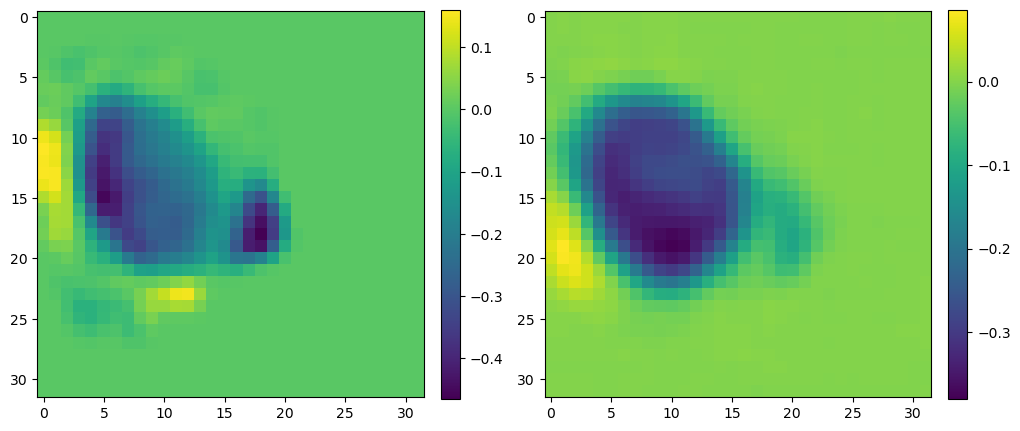

In [58]:
print(input_.shape, out_.shape)
batch_size = 0
time = 5
channel = 1
fig, axs = plt.subplots(1,2, figsize = (12,12))
ax = axs.ravel()

plt.colorbar(ax[0].imshow(input_[batch_size,channel,:,:,time]), fraction=0.046, pad=0.04)
plt.colorbar(ax[1].imshow(out_[batch_size,channel,:,:,time]), fraction=0.046, pad=0.04)
#plt.colorbar(ax[0].imshow(input_[batch_size,channel,:,:,time], vmin = -0.8, vmax = 0.1, cmap = 'gray'), fraction=0.046, pad=0.04)
#plt.colorbar(ax[1].imshow(out_[batch_size,channel,:,:,time], vmin = -0.8, vmax = 0.1, cmap = 'gray'), fraction=0.046, pad=0.04)
#ax[0].imshow(input_[batch_size,channel,:,:,time])
#ax[1].imshow(out_[batch_size,channel,:,:,time])



In [59]:
# Testing the model best checkpoint
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(z_dim=32, in_channels=4, gf_dim=8).to(device)

best_epoch_model = glob.glob(experiment_path + '/' + '*best*')[0]

torch.Size([10, 256, 2, 2, 3])
torch.Size([10, 4, 32, 32, 24])


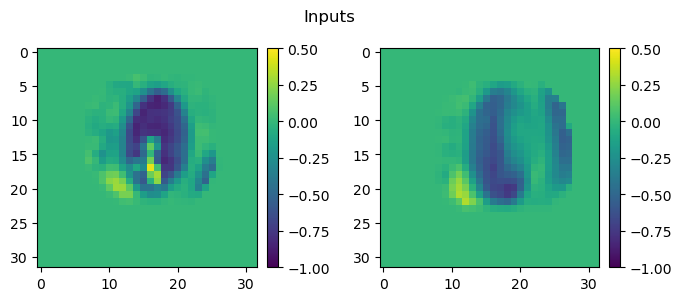

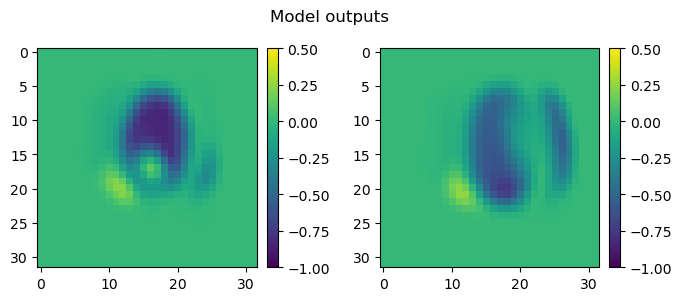

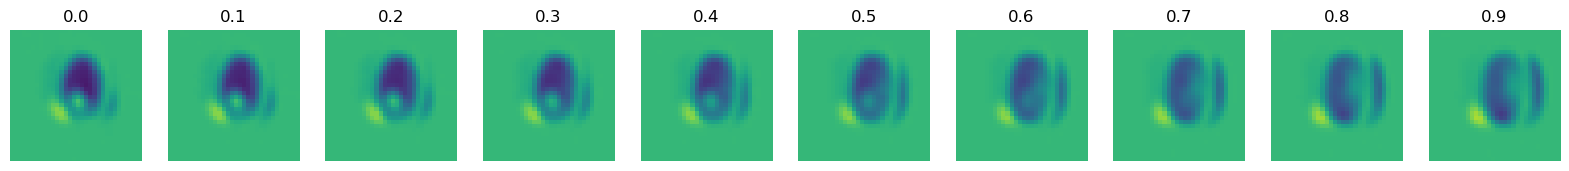

In [60]:
viz(images, best_epoch_model, c = 1, t = 3, scale_colorbar = True, i1=32, i2=96)

#### Model with best validation loss

In [42]:
best_val_model = '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0'
best_val_sweep = 'rkinsla9'
log_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/logs/vae/masked_slice'
if best_val_sweep:
    best_val_log_path = os.path.join(log_path, best_val_sweep)
best_val_experiment_path = os.path.join(best_val_log_path, best_val_model)
os.listdir(best_val_experiment_path)

['intermediate_results',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-0',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-best',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-10',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-20',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-30',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-40',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-50',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-60',
 '20230530-1102_masked_slice_lr2.419e-04-e80-bs3-zdim2888-daTrue-f25.0.ckpt-70']

In [43]:
best_gen_model = '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0'
best_gen_sweep = 'rkinsla9'
log_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/logs/vae/masked_slice'
if best_gen_sweep:
    best_gen_log_path = os.path.join(log_path, best_gen_sweep)
best_gen_experiment_path = os.path.join(best_gen_log_path, best_gen_model)
os.listdir(best_gen_experiment_path)

['intermediate_results',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-0',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-best',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-10',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-20',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-30',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-40',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-50',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-60',
 '20230530-2007_masked_slice_lr3.819e-04-e80-bs3-zdim2888-daTrue-f150.0.ckpt-70']

#### Interpolation

In [44]:
best_val_model_path = glob.glob(best_val_experiment_path + '/' + '*best*')[0]
best_gen_model_path = glob.glob(best_gen_experiment_path + '/' + '*best*')[0]

torch.Size([10, 256, 2, 2, 3])
torch.Size([10, 4, 32, 32, 24])


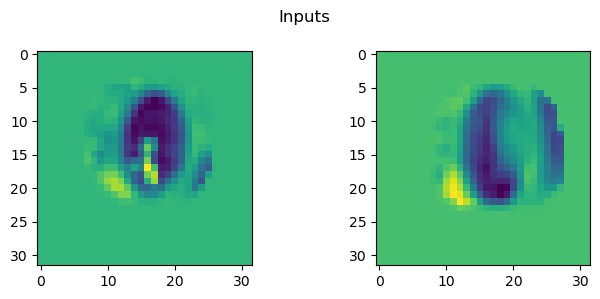

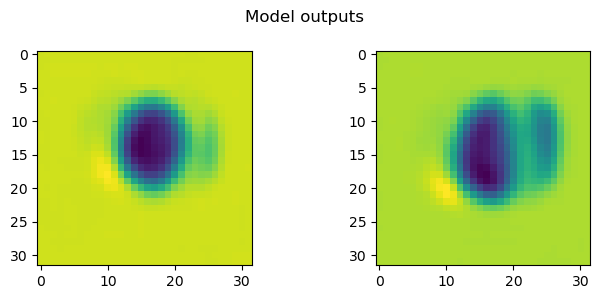

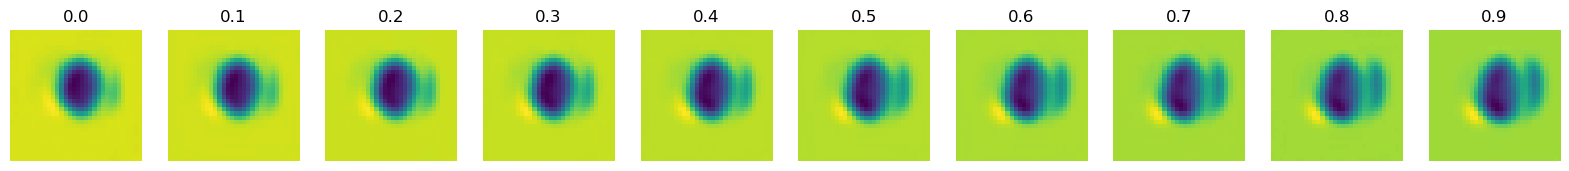

In [45]:
viz(images, best_val_model_path, c = 1, t = 3, scale_colorbar=False)

torch.Size([10, 256, 2, 2, 3])
torch.Size([10, 4, 32, 32, 24])


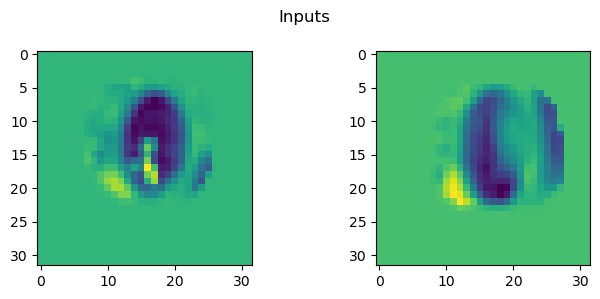

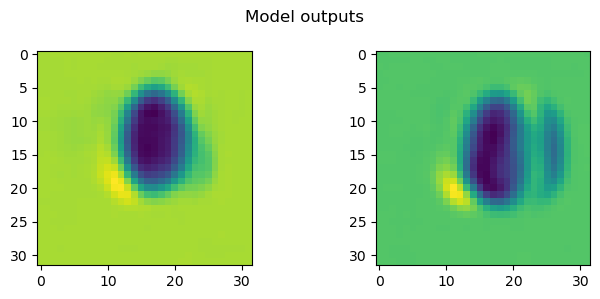

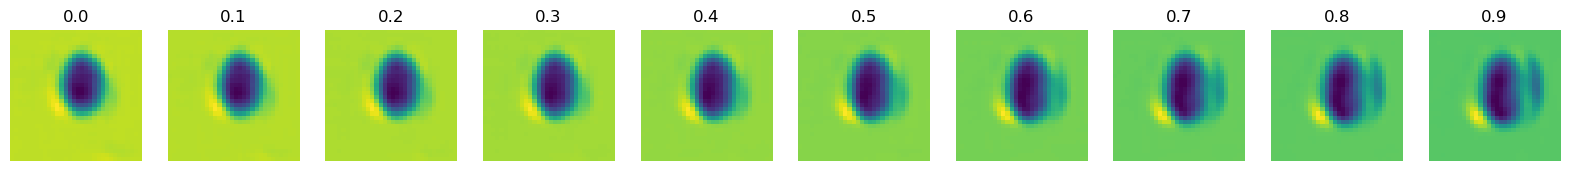

In [46]:
viz(images, best_gen_model_path, c = 1, t = 3, scale_colorbar= False)

torch.Size([10, 256, 2, 2, 3])
torch.Size([10, 4, 32, 32, 24])


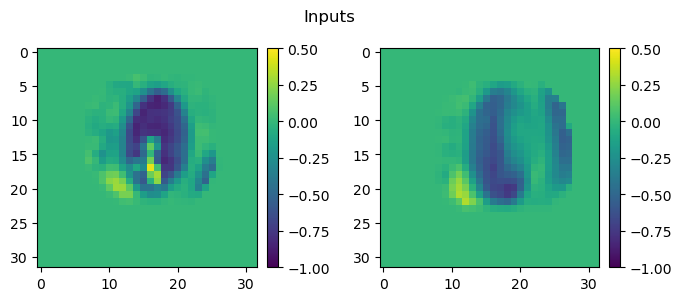

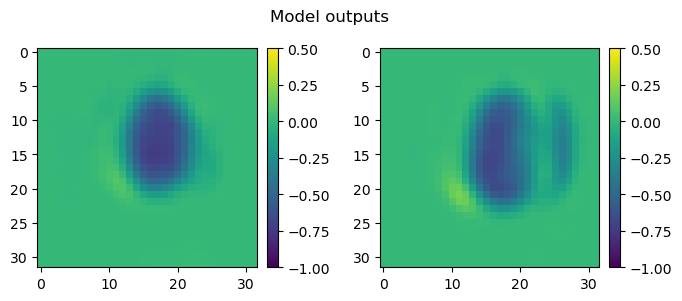

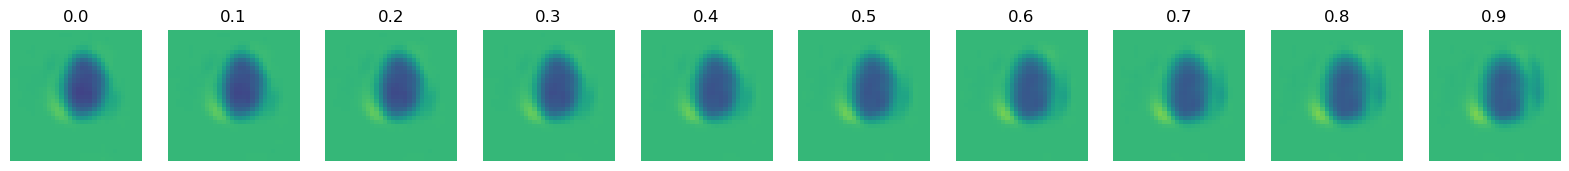

In [47]:
viz(images, best_gen_model_path, c = 1, t = 3, scale_colorbar= True)